# Huang1980 for Twilite and Image-Derived Input Functions

## Setup

In [1]:
# system functions that are always useful to have
import time, sys, os
from pprint import pprint

try:
    import numpy as np
    print("numpy is available")  # numpy is available; Jupyter linter has an issue with numpy
except ImportError:
    print("numpy is not available")
# import numpy as np 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))


numpy is available


In [2]:
from PETUtilities import PETUtilities
from IOImplementations import BaseIO
from RBCPartition import RBCPartition
from Huang1980Context import Huang1980Context

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# everything is decay corrected

kerndir = os.path.join(os.getenv("HOME"), "PycharmProjects", "dynesty", "idif2024", "data", "kernels")
kern = os.path.join(kerndir, "kernel_hct=46.8.nii.gz")

fdgdir = os.path.join(os.getenv("HOME"), "PycharmProjects", "dynesty", "idif2024", "data", "ses-20210421155709", "pet")
pet = os.path.join(fdgdir, "sub-108293_ses-20210421155709_trc-fdg_proc-delay0-BrainMoCo2-createNiftiMovingAvgFrames_timeAppend-165-ParcSchaeffer-reshape-to-schaeffer-schaeffer.nii.gz")

idif_embed = os.path.join(fdgdir, "sub-108293_ses-20210421155709_trc-fdg_proc-MipIdif_idif.nii.gz")
idif_deconv = os.path.join(fdgdir, "sub-108293_ses-20210421155709_trc-fdg_proc-MipIdif_idif-BoxcarIO-ideal.nii.gz")  # deconv., decay corrected
idif = idif_embed
# idif = PETUtilities.nii_hstack(idif_deconv, idif_embed, t_crossover=300, output_format="fqfn")

twil_embed = os.path.join(fdgdir, "sub-108293_ses-20210421155709_trc-fdg_proc-TwiliteKit-do-make-input-func-nomodel_inputfunc-embed.nii.gz")  # no deconv., decaying
twil_deconv = os.path.join(fdgdir, "sub-108293_ses-20210421155709_trc-fdg_proc-TwiliteKit-do-make-input-func-nomodel_inputfunc-RadialArteryIO-ideal.nii.gz")  # deconv., decaying, ~470 sec
twil = twil_embed
# twil = PETUtilities.nii_hstack(twil_deconv, twil_embed, t_crossover=300, output_format="fqfn")

codir = os.path.join(os.getenv("HOME"), "PycharmProjects", "dynesty", "idif2024", "data", "ses-20210421144815", "pet")
v1_idif = os.path.join(codir, "sub-108293_ses-20210421144815_trc-co_proc-delay0-BrainMoCo2-createNiftiMovingAvgFrames-ParcSchaeffer-reshape-to-schaeffer-schaeffer-idif_martinv1.nii.gz")
v1_twil = os.path.join(codir, "sub-108293_ses-20210421144815_trc-co_proc-delay0-BrainMoCo2-createNiftiMovingAvgFrames-ParcSchaeffer-reshape-to-schaeffer-schaeffer-twilite_martinv1.nii.gz")



RBCPartition t_crossover: 35


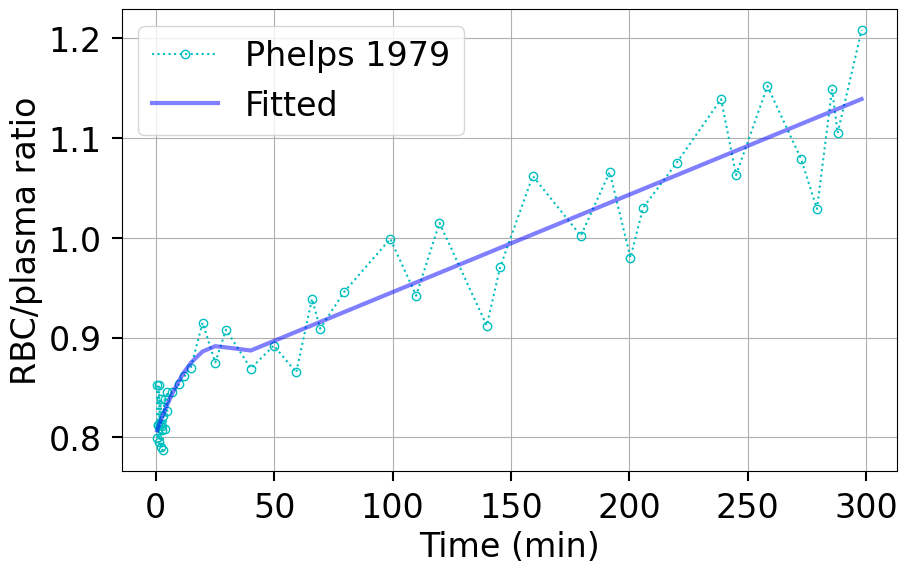

In [4]:
rbcp = RBCPartition(hct=46.8)
print(f"RBCPartition t_crossover: {rbcp.t_crossover}")
rbcp.plot()

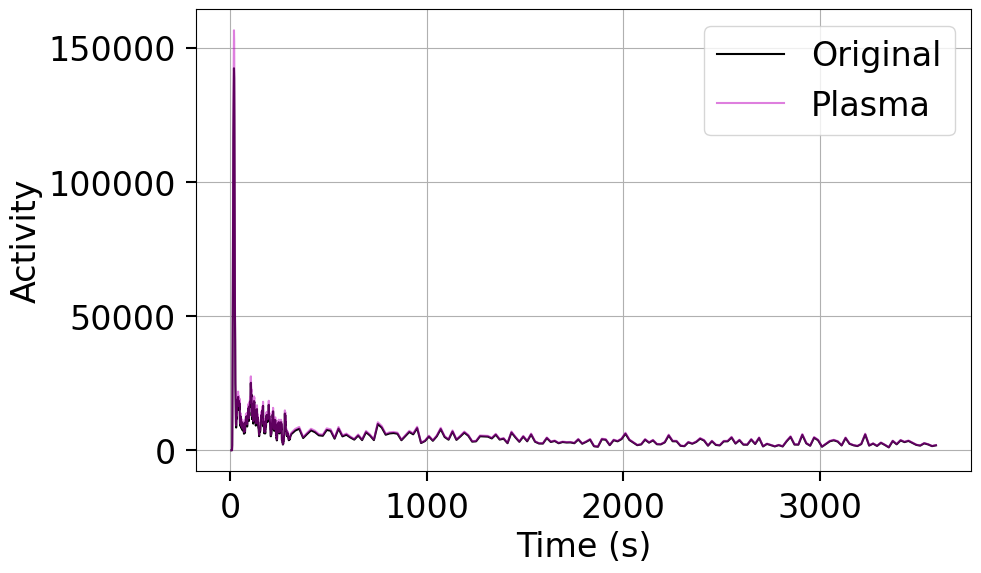

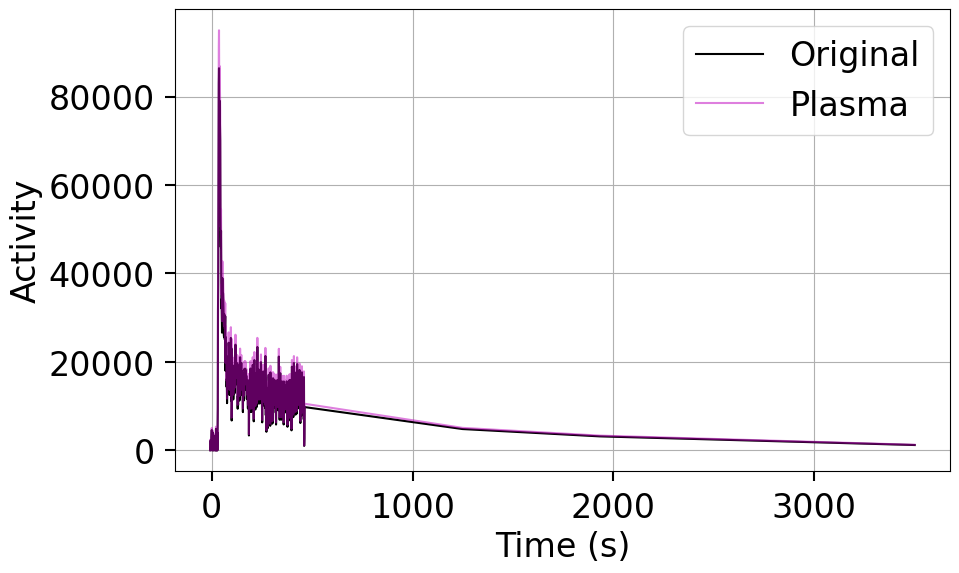

In [8]:
idif0 = BaseIO().nii_load(idif)
idif1 = rbcp.nii_wb2plasma(idif, output_format="niid")
plt.figure(figsize=(10,6))
plt.plot(idif0["timesMid"], idif0["img"], 'k-', label='Original')
plt.plot(idif1["timesMid"], idif1["img"], 'm-', alpha=0.5, label='Plasma')
plt.xlabel('Time (s)')
plt.ylabel('Activity')
plt.grid(True)
plt.legend()
plt.show()

twil0 = BaseIO().nii_load(twil)
twil1 = rbcp.nii_wb2plasma(twil, output_format="niid")
plt.figure(figsize=(10,6))
plt.plot(twil0["timesMid"], twil0["img"], 'k-', label='Original')
plt.plot(twil1["timesMid"], twil1["img"], 'm-', alpha=0.5, label='Plasma')
plt.xlabel('Time (s)')
plt.ylabel('Activity')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
data_dict_idif = {
    "input_func_fqfn": idif,
    "tissue_fqfn": pet,
    "v1_fqfn": v1_idif,
    "nlive": 1000,
    "tag": "playground_Huang1980_idif"
}
data_dict_twil = {
    "kernel_fqfn": kern,
    "input_func_fqfn": twil,
    "tissue_fqfn": pet,
    "v1_fqfn": v1_twil,
    "nlive": 1000,
    "tag": "playground_Huang1980_twil"
}

truth_huang_idif = [
    0.0239558853209019, 0.00413282308727503, 0.0017321293707937, 0.00038140409742482, 
    0.0623763054609299, -20.7800941467285, 0.0427906289696693
]
truth_huang_twil = [
    0.408246487379074, 0.109803847968578, 0.00364328804425895, 0.000151538042700849, 
    10.5196905136108, -43.4790229797363, 0.0226653199642897
]
huang_idif = Huang1980Context(data_dict_idif)
huang_twil = Huang1980Context(data_dict_twil)

parc_index = 25  # caudate

## Inspect Huang1980Context twil

In [ ]:
huang_twil.plotting.truths_plot(truths=truth_huang_twil, parc_index=parc_index)

Let's sample from this distribution using the default `dynesty` settings with `'slice'`.

In [5]:
# de novo, thalamus ~ 6, 25
res_twil = huang_twil.solver.run_nested(print_progress=True, parc_index=range(10))

In [ ]:
huang_twil.plotting.results_plot(tag="playground_Huang1980_twil", parc_index=9)

In [ ]:
huang_twil.plotting.parcs_plot()

## Inspect Huang1980Context idif

In [ ]:
huang_idif.plotting.truths_plot(truths=truth_huang_idif, parc_index=parc_index)

Let's sample from this distribution using the default `dynesty` settings with `'slice'`.

In [9]:
# de novo, thalamus ~ 6, 25
res_idif = huang_idif.solver.run_nested(print_progress=True, parc_index=range(10))

In [ ]:
huang_idif.plotting.results_plot(tag="playground_Huang1980_idif", parc_index=9)

In [ ]:
huang_idif.plotting.parcs_plot()

In [ ]:
huang_twil.data.print_truths()
huang_idif.data.print_truths()

In [ ]:
pprint(huang_twil.solver.truths)
pprint(huang_idif.solver.truths)